# V2 : NON-LEARNABLE SPATIAL ESTIMATOR

### Datasets used for this version :
    - GHSL FUA, POP, BUILT-H
    - VIIRS Nightlight
    - MS Buildings

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import rasterio
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import shapely
from to_degree import to_degree
from region_new import Region, emission_nlse

In [2]:
# bounding boxes and FUA's
bounding_box = json.load(open('bounding_box.json'))

In [3]:
# yearly average ntl
ntl_path = os.path.join ('data','ntl','ntl_avg_2101.tif') 
# monthly average (fixed month)
lst_path = os.path.join ('data','lst','')
pop_path = os.path.join ('data','pop','')
height_path = os.path.join('data', 'height', '')

In [4]:
# house data
ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

In [24]:
cities = dict(
    Adana = dict(
        box= bounding_box["Adana"]["box"],
        fua= bounding_box["Adana"]["fua"],
        name = "Adana",
        house = adana_house
    ),
    Cairo = dict(
        box= bounding_box["Cairo"]["box"],
        fua= bounding_box["Cairo"]["fua"],
        name = "Cairo",
        house = cairo_house
    ),
    Johannesburg = dict(
        box= bounding_box["Johannesburg"]["box"],
        fua= bounding_box["Johannesburg"]["fua"],
        name = "Johannesburg",
        house = johannesburg_house
    ),
)

In [25]:
Cities = {}
resolution = (-500, 500)
#resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, fua, name, house = val["box"], val["fua"], val["name"], val["house"]
    city = Region(val["box"])
    # Parse FUA edges from JSON
    fua = shapely.geometry.Polygon(fua)
    fua = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[fua])
    # FUA edges
    city.add_layer(layer_name="fua", 
                   geo_data=fua, 
                   layer_type="vector", 
                   box=box, 
                   meta="Functional Urban Area")
    
    # Population density
    city.add_layer(layer_name="pop", 
                   geo_data=pop_path+name+'.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="pop", 
                   meta="Population")
    
    # MS building
    house = geopandas.read_file(house)
    house['density']=1
    house = house.to_crs("EPSG:3395")
    house['area']= house["geometry"].area
    house = house.to_crs("EPSG:4326")
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
    
    # NTL
    city.add_layer(layer_name="ntl", 
                   geo_data=ntl_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="ntl", 
                   meta="Nighttime Light")
    
    city.add_layer(layer_name="height", 
                   geo_data=height_path+name+'.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="height", 
                   meta="GHSL BUILT-H")
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster_100",
                                res_type="meter")
    # unify tMS_raster_100he projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster_100", 
                    raster_list={
                        "pop":(["pop"],"nearest"),
                        "ntl":(["ntl"],"nearest"),
                        "height":(["height"], "nearest")
                        }
                    )
    
    
    # estiamte co2 emission with simple function
    city.output = city.output.assign(emission = emission_nlse)
    Cities[key] = city           
    print(city.output)                                                                       

Adana


/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.Dataset>
Dimensions:      (x: 85, y: 40, band: 1)
Coordinates:
  * x            (x) float64 3.906e+06 3.906e+06 ... 3.947e+06 3.948e+06
  * y            (y) float64 4.423e+06 4.422e+06 ... 4.404e+06 4.403e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area         (y, x) float64 0.0 0.0 3.111e+03 127.4 0.0 ... 0.0 0.0 0.0 0.0
    density      (y, x) float64 0.0 0.0 27.0 4.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pop          (band, y, x) float64 nan nan nan nan ... -200.0 -200.0 -200.0
    ntl          (band, y, x) float32 nan nan nan nan ... 1.56 1.53 1.56 1.49
    height       (band, y, x) float32 nan nan nan nan ... -1.0 -1.0 -1.0 -1.0
    emission     (y, x, band) float64 nan nan nan nan ... -0.0 -0.0 -0.0 -0.0
Cairo


/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.Dataset>
Dimensions:      (x: 173, y: 331, band: 1)
Coordinates:
  * x            (x) float64 3.44e+06 3.44e+06 3.441e+06 ... 3.525e+06 3.526e+06
  * y            (y) float64 3.554e+06 3.553e+06 ... 3.389e+06 3.389e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area         (y, x) float64 0.0 125.2 2.838e+03 79.53 ... 0.0 0.0 0.0 0.0
    density      (y, x) float64 0.0 1.0 22.0 2.0 48.0 ... 0.0 0.0 0.0 0.0 0.0
    pop          (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ntl          (band, y, x) float32 nan 4.47 4.15 3.54 ... nan nan nan nan
    height       (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    emission     (y, x, band) float64 nan nan nan nan nan ... nan nan nan nan
Johannesburg


/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.Dataset>
Dimensions:      (x: 210, y: 180, band: 1)
Coordinates:
  * x            (x) float64 3.069e+06 3.07e+06 3.07e+06 ... 3.173e+06 3.174e+06
  * y            (y) float64 -2.953e+06 -2.954e+06 ... -3.042e+06 -3.043e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area         (y, x) float64 0.0 0.0 0.0 0.0 1.716e+03 ... 0.0 0.0 0.0 0.0
    density      (y, x) float64 0.0 0.0 0.0 0.0 3.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pop          (band, y, x) float64 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ntl          (band, y, x) float32 1.09 0.83 0.83 0.77 ... nan nan nan nan
    height       (band, y, x) float32 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan
    emission     (y, x, band) float64 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan


In [7]:
# dump city
dump_path = os.path.join("data","Cities_v2_nlse.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

## RESULTS

In [8]:
# load city
dump_path = os.path.join("data","Cities_v2_nlse.pickle")
with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)

In [35]:
cairo = Cities['Cairo']
adana = Cities['Adana']
johannesburg = Cities['Johannesburg']

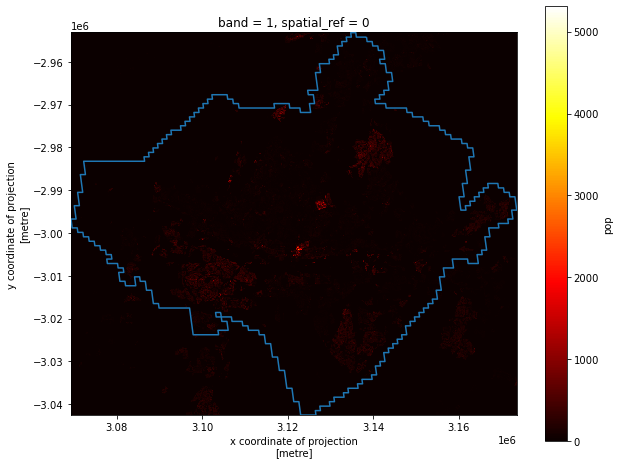

In [39]:
# FUA + population density

ax = johannesburg.vector["fua"].geo_df.boundary.plot(zorder=999,figsize=(10,8))
johannesburg.raster["pop"].tiff.pop.plot(cmap="", ax=ax)

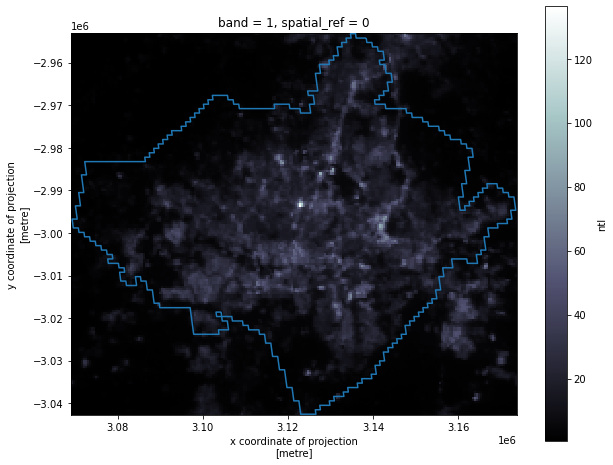

In [40]:

ax = johannesburg.vector["fua"].geo_df.boundary.plot(zorder=999,figsize=(10,8))
johannesburg.raster["ntl"].tiff.ntl.plot(cmap="bone", ax=ax)

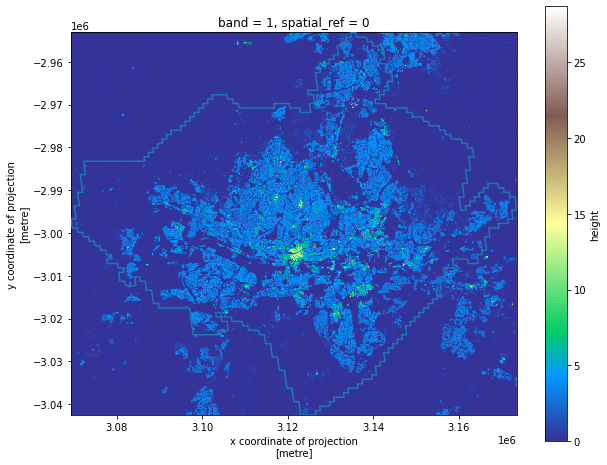

In [41]:
ax = johannesburg.vector["fua"].geo_df.boundary.plot(zorder=999,figsize=(10,8))
johannesburg.raster["height"].tiff.height.plot(cmap='terrain', ax=ax)

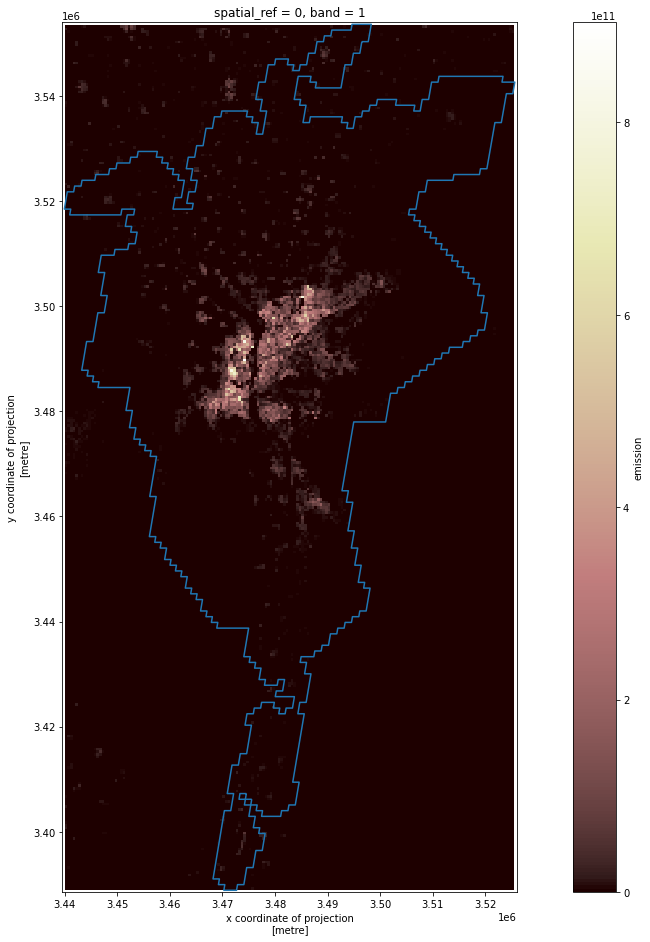

In [31]:
# Emission weights 
ax  = cairo.vector["fua"].geo_df.boundary.plot(zorder=999,figsize=(20,16))
cairo.output.emission.plot(cmap="pink", ax=ax)

### DISPLAY TIFF RESULTS

In [5]:
import xarray as xr
result_path = os.path.join('data', 'results', '')
city = 'adana'
result = xr.open_dataset(result_path+city+'.tif')

In [8]:
result

<xarray.Dataset>
Dimensions:      (band: 1, x: 85, y: 40)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.906e+06 3.906e+06 ... 3.947e+06 3.948e+06
  * y            (y) float64 4.423e+06 4.422e+06 ... 4.404e+06 4.403e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

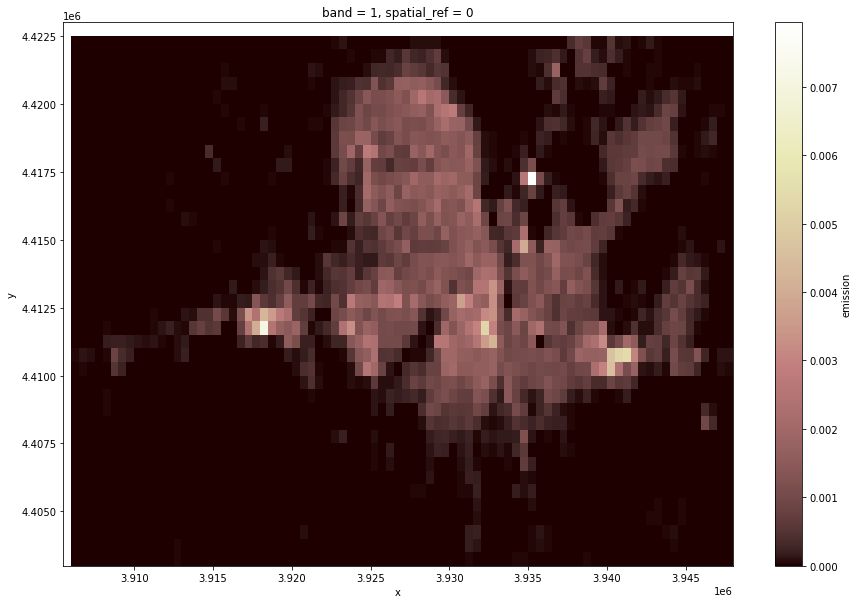

In [12]:
result.band_data.plot(cmap="pink", figsize=(15,10))

#### Some illustrative difference maps :
    - population vs building height
    - building density vs nighttime light

In [14]:
ordu.normalize_output()

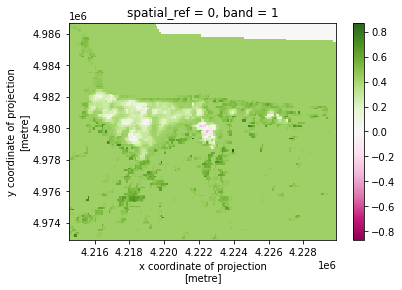

In [25]:
ordu.difference_map('pop', 'height')

**In White** : population density is correlated to building height  
**In Green** : population density is high despite lower building height  
**In Pink** : population is low despite high building height (working / industrial distric ?)

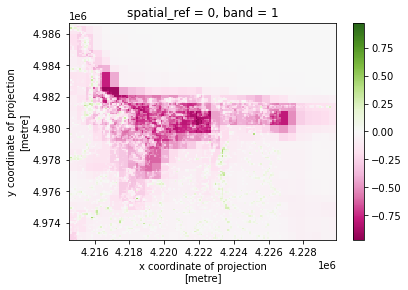

In [27]:
ordu.difference_map('density', 'ntl')

**In White** : Correlated  
**In Pink** : High NTL despite lower density (probably due to light diffusion + lower resolution)

In [6]:
file = os.path.join('data', 'clipped_house', 'Ordu.json')
df = geopandas.GeoDataFrame.from_file(file)

<AxesSubplot:>

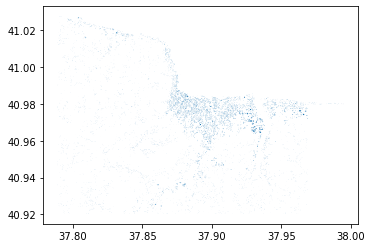

In [9]:
df[:10000].plot()